<a href="https://colab.research.google.com/github/a503032123/DSML_booking.com/blob/master/%E2%80%9CDSML_104403041_A8_ipynb%E2%80%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

Try to imporvement the experiment



**last time:** 

Model:Naive Bayes


Feature engineering:tfidf, word2vec 

**Methods I try**


change model about CNN

Try POStag,PCA,NamedEntity

===========================================================================================================================


In [1]:
import numpy as np
import pandas as pd
import nltk

nltk.download("popular")
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import preprocessing

!pip3 install pydrive

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

In [0]:
#Loading the training data.

#Firstly, conducting the authentication on google drive. 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
drive = GoogleDrive(gauth) #Create GoogleDrive instance with authenticated GoogleAuth instance

#See my file in A2 folder(1RHLLHMpY....)
file_list = drive.ListFile({'q': "'1snGpUVTrGOHMmaeOXdfZfej3p9tXdsSP' in parents and trashed=false"}).GetList()
for file in file_list:
  print('title: %s, id: %s' % (file['title'], file['id']))

title: Final_Paper.pdf, id: 1IRdlDOoiceT38f6u7viWyxUcmWpYRqx0
title: clean_dataset.csv, id: 1XycH_rePLI3VcUc74gHu1CKSQUBNajK6
title: Final_Paper.doc, id: 136tivaDvC-Gu7mJigAZf9sjN54ePpUO-
title: Experiment Results.xlsx, id: 1xi3lcZbsbF7gzmpp80YrvjhO6emaPl9t
title: notebook, id: 1Dz8GOy7pV2roku2HBp3JdYpBrrVQ6a9W
title: figure, id: 1mhU-7FPdx8glFhkjB0CCqnEvbAWl9gdR


# Preprocessing

In [0]:
csv_from_gdrive = drive.CreateFile({'id': '1XycH_rePLI3VcUc74gHu1CKSQUBNajK6'})
csv_from_gdrive.GetContentFile('data.csv')
data = pd.read_csv('data.csv')

In [0]:
#Missing value: Drop the reviews with missing value directly.
data.dropna(inplace = True)
data.drop('Unnamed: 0', 1, inplace =True)
data.reset_index(drop = True, inplace = True)
#500717 records

In [0]:
#One-side Reviews: Remove the review with "No Negative"/"No Positive". 
data['NegativeReview'].replace('No Negative', "+", inplace = True)
data['PositiveReview'].replace('No Positive', "-", inplace = True)

In [0]:
#Combine: Positive and negative reviews would be treated as only a review, and in addition : lower the case. 
corpus = data.NegativeReview + data.PositiveReview
data.insert(0, "Review", corpus.str.lower())


In [0]:
#delete not use coloum
data.drop('NegativeReview', 1, inplace =True)
data.drop('PositiveReview', 1, inplace =True)
list(data)

['Review', 'TripStyle']

資料量過大 電腦無法處理因此隨機取出其中的四成做實驗

In [0]:
from sklearn.model_selection import train_test_split
x=data
x_train, x_test = train_test_split(x,test_size = 0.6, shuffle = True)
data=x_train
print(len(data.Review))
#200286 records

200286


In [0]:
#Tokenization: Conduct the work_tokenize first. (sent_tokenizing is more complicated in this case.)
from nltk.tokenize import sent_tokenize, word_tokenize
#data = data.join(data.TEXT.apply(sent_tokenize).rename('SENTENCES'))
#sent = data.NegativeReview.apply(sent_tokenize)
word = data.Review.apply(word_tokenize)
data.insert(0, 'WordToken', word)

In [0]:
#Anomaly, Weird records: Drop the  review   remove the review with less than 5 words
word_count = data.WordToken.apply(lambda x: len(x))
filter_count = (word_count >= 1)
data = data[filter_count]
data.reset_index(drop = True, inplace = True)
#Now the total records are 500487
print(len(data.Review))

200261


In [0]:
#StopWordRemoval: Remove the NLTK build-in stopwords in all the records.
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
wosw = data.WordToken.apply(lambda x: [ item for item in x if item not in stop_words ])
#Casefold: In order to do the vectorization

In [0]:
#postag
from nltk.chunk import conlltags2tree, tree2conlltags
from nltk import ne_chunk ,pos_tag
#pattern = 'NP: {<DT>?<JJ>*<NN>}'
data2= data.WordToken.apply(pos_tag)
#data2=nltk.pos_tag(word)
#data2=ne_chunk(pos_tag(word_tokenize(data.Review)))

data.insert(0, 'pos', data2)
print(data.pos)

0         [(the, DT), (equipment, NN), (in, IN), (the, D...
1         [(the, DT), (breakfast, NN), (waitresses, VBZ)...
2         [(the, DT), (staff, NN), (were, VBD), (friendl...
3         [(would, MD), (have, VB), (been, VBN), (nice, ...
4         [(some, DT), (staff, NN), (a, DT), (bit, NN), ...
5         [(lots, NNS), (of, IN), (space, NN), (but, CC)...
6         [(some, DT), (of, IN), (the, DT), (workers, NN...
7         [(the, DT), (location, NN), (quite, RB), (a, D...
8         [(+, IN), (the, DT), (staff, NN), (were, VBD),...
9         [(awful, JJ), (bed, VBD), (very, RB), (poor, J...
10                                  [(none, NN), (all, DT)]
11        [(the, DT), (staff, NN), (were, VBD), (quite, ...
12        [(wifi, JJ), (connection, NN), (was, VBD), (ve...
13                                 [(price, NN), (all, DT)]
14        [(+, IN), (the, DT), (staff, NN), (was, VBD), ...
15        [(+, VB), (this, DT), (hotel, NN), (was, VBD),...
16        [(+, JJ), (kattoterassi, NN), 

In [0]:
#nltk to name entity but the tree is too big to convert

#cp = nltk.RegexpParser(pattern)
#cs = data.pos.apply(cp.parse)
#prodata=nltk.pos_tag(data.WordToken)
#cs = ne_chunk(data.pos)
#iob_tagged = tree2conlltags(cs)
#print(iob_tagged)
#data.insert(0, 'iob_tagged',iob_tagged)


In [0]:
#spacy for name entity
#import spacy
#from spacy import displacy
#from collections import Counter
#import en_core_web_sm
#nlp = en_core_web_sm.load()

In [0]:

#doc = data.Review.apply(nlp)
#data.insert(0, 'named_entity',doc)

In [0]:
#print(data.named_entity)

In [0]:
#Lemmatization: Convert the terms with different representations into the original.
from nltk.stem import WordNetLemmatizer

wnl = WordNetLemmatizer()
def lemmatize_text(text):
   return [wnl.lemmatize(w) for w in text]

data.insert(0, 'Lemmatized',wosw.apply(lemmatize_text))



In [0]:
#list(data)

['pos', 'Lemmatized', 'WordToken', 'Review', 'TripStyle']

# Feature Engineering

use TFIDF and WordRmbedding

In [0]:
#Vectorize I: Bow with TFIDF transformation.
def dum(doc):
    return doc

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(analyzer = 'word', 
                             tokenizer = dum,
                             ngram_range = (1,1),
                             min_df=5000,
                             preprocessor = dum)
x = vectorizer.fit_transform(data.WordToken)

# 79567 dimensions

In [0]:
#use name entity/postag fit
x = vectorizer.fit_transform(data.pos)

In [0]:
tfidfvec = x.toarray()

In [0]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
le = LabelEncoder()
x_ = tfidfvec
lbl_ = le.fit_transform(data['TripStyle'])
# 1 for Leisure trip, 0 for Business

#lbl_ = to_categorical(lbl_)#使用CNN時lbl要再一次轉換Naive Bayes不用這行
#Split them into train/test set, randomly with the test size 0.33 
from sklearn.model_selection import train_test_split
x_train, x_test, lbl_train, lbl_test = train_test_split(x_, lbl_ , test_size = 0.33, shuffle = True)


In [0]:
#Vectorize II: WordEmbedding by Gensim.
from gensim.models import Word2Vec, KeyedVectors
from gensim.test.utils import common_texts, get_tmpfile
model = Word2Vec(size = 300, window = 2, min_count = 1)
#In order to count the single-word review, cfg with two word window and one count.

#Building the dictionary.
model.build_vocab(data.WordToken)

#Train the w2v model with WordTokens
model.train(data.WordToken, total_examples = len(data.WordToken), epochs = 1)
model.init_sims(replace=True)

In [0]:
#To lower the memory usage, save/load in KV model is necessary...
fpath = get_tmpfile("w2v.kv")
model.wv.save(fpath)
del model
wv = KeyedVectors.load(fpath, mmap='r')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
#Document vector: By simply get the average of the wordvec in the single doc.
def doc_vec(doc):  
    doc = [word for word in doc] # target input list of words
    return np.mean(wv[doc], axis = 0)

vec = np.vstack(data.WordToken.apply(doc_vec))  #not sure abou whether a more efficient way

In [0]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
le = LabelEncoder()
#x_ = countvec
#x_ = tfidfvec
#x_ = w2vdvec
x_ = vec
lbl_ = le.fit_transform(data['TripStyle'])   # 1 for Leisure trip, 0 for Business
#lbl_ = to_categorical(lbl_)
#Split them into train/test set, randomly with the test size 0.33 
from sklearn.model_selection import train_test_split
x_train, x_test, lbl_train, lbl_test = train_test_split(x_, lbl_ , test_size = 0.33, shuffle = True)





In [0]:
#demision reduce:pca
from sklearn.decomposition import PCA
print(x_train.shape)
pca = PCA(n_components=0.9)  
x_train = pca.fit_transform(x_train)  
x_test = pca.transform(x_test) 
print(x_train.shape)

(134174, 161)
(134174, 119)


# Modeling

naive_bayes and cnn

In [0]:
import keras
import numpy as np
import sklearn.metrics as sklm

In [0]:
from sklearn.naive_bayes import GaussianNB
clf_gnb = GaussianNB()
clf_gnb.fit(x_train, lbl_train)

GaussianNB(priors=None, var_smoothing=1e-09)

CNN

In [0]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D,Conv1D,MaxPooling1D
from keras import backend as K
from keras.layers import Input,  Embedding
from keras.layers import Reshape

In [0]:
#維度調整
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1],1,1)
x_test = x_test.reshape(x_test.shape[0], x_train.shape[1] ,1, 1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

print('x_train shape :',x_train.shape)
print(x_train.shape[0] ,'train_samples')
print(x_test.shape[0] ,'train_samples')

x_train shape : (134174, 249, 1, 1)
134174 train_samples
66087 train_samples


In [0]:
batch_size = 128
num_classes = 2
epochs = 6
inputshape=(x_train.shape[1],1,1)


In [0]:
model = Sequential()
model.add(Conv2D(1, kernel_size=(1,1),
                activation ='relu',
                input_shape=inputshape))
model.add(Conv2D(1,(1,1),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(1,1)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

W0614 02:57:37.511336 140623698663296 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0614 02:57:37.566190 140623698663296 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0614 02:57:37.577272 140623698663296 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0614 02:57:37.619737 140623698663296 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0614 02:57:37.623108 140623698663296 deprecation_wrapp

In [0]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 249, 1, 1)         2         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 249, 1, 1)         2         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 249, 1, 1)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 249, 1, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 249)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32000     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [0]:
print("Traning Model...")
model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adadelta(),
             metrics=['acc'])
model.fit(x_train,lbl_train,
         batch_size=batch_size,
         epochs=epochs,
         verbose =1,
         # callbacks=[],
         validation_data=(x_test,lbl_test))
score= model.evaluate(x_test,lbl_test,verbose=0)
print('Test loss:',score[0])
print('Test accuracy:',score[1])




W0614 02:57:47.716515 140623698663296 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0614 02:57:47.732040 140623698663296 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0614 02:57:47.876490 140623698663296 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Traning Model...
Train on 134174 samples, validate on 66087 samples
Epoch 1/6
134174/134174 [==============================] - 13s 101us/step - loss: 0.4967 - acc: 0.8329 - val_loss: 0.4514 - val_acc: 0.8329
Epoch 2/6
134174/134174 [==============================] - 6s 41us/step - loss: 0.4502 - acc: 0.8336 - val_loss: 0.4513 - val_acc: 0.8329
Epoch 3/6
134174/134174 [==============================] - 6s 42us/step - loss: 0.4502 - acc: 0.8336 - val_loss: 0.4513 - val_acc: 0.8329
Epoch 4/6
134174/134174 [==============================] - 6s 42us/step - loss: 0.4502 - acc: 0.8336 - val_loss: 0.4513 - val_acc: 0.8329
Epoch 5/6
134174/134174 [==============================] - 6s 41us/step - loss: 0.4502 - acc: 0.8336 - val_loss: 0.4513 - val_acc: 0.8329
Epoch 6/6
134174/134174 [==============================] - 6s 42us/step - loss: 0.4502 - acc: 0.8336 - val_loss: 0.4513 - val_acc: 0.8329
Test loss: 0.4512647079181229
Test accuracy: 0.8329020836170502


In [0]:
loss, accuracy = model.evaluate(x_test, lbl_test, verbose=1)
print('Accuracy: %f' % (accuracy*100))

66087/66087 [==============================] - 3s 51us/step
Accuracy: 83.290208


In [0]:
lbl_pred = model.predict(x_test)

In [0]:
from sklearn.metrics import classification_report
lbl_pred1 = np.where(lbl_pred > 0.8 , 1, 0)
print(classification_report(lbl_test, lbl_pred1))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00     11043
           1       0.83      1.00      0.91     55044

   micro avg       0.83      0.83      0.83     66087
   macro avg       0.42      0.50      0.45     66087
weighted avg       0.69      0.83      0.76     66087
 samples avg       0.83      0.83      0.83     66087



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Evaluation

for naive bayes

In [0]:
#Evaluation function:
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix, accuracy_score, classification_report
from imblearn.metrics import classification_report_imbalanced
import matplotlib.pyplot as plt

#ref: https://acutecaretesting.org/en/articles/precision-recall-curves-what-are-they-and-how-are-they-used
def evaluating(truth, pred, ax=object):
  
    print(accuracy_score(truth, pred))
    print(classification_report_imbalanced(truth, pred))    
    print(confusion_matrix(truth, pred))
    precision, recall, threshold = precision_recall_curve(truth, pred)

    ax.step(recall, precision, color='b', alpha=1, where='post')
    ax.fill_between(recall, precision, step='post', alpha=0.5, color='b')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_ylim([0.0, 1.05])
    ax.set_xlim([0.0, 1.0])
    ax.set_title('Precision-Recall curve')
    return ax
#ref: https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

0.7830738269251138
                   pre       rec       spe        f1       geo       iba       sup

          0       0.26      0.17      0.90      0.21      0.39      0.14     10860
          1       0.85      0.90      0.17      0.87      0.39      0.17     55227

avg / total       0.75      0.78      0.29      0.76      0.39      0.16     66087

[[ 1862  8998]
 [ 5338 49889]]


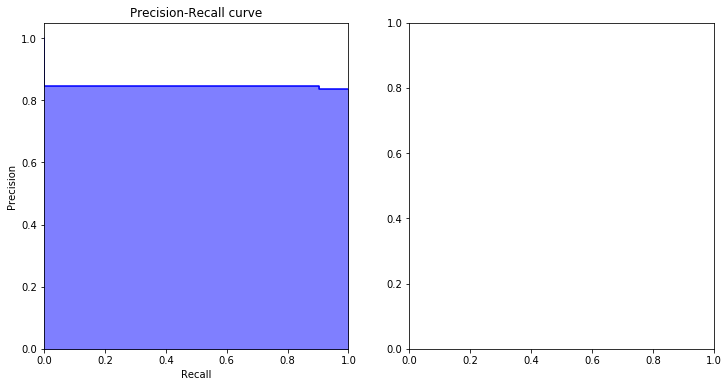

In [0]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

pred_gnb = clf_gnb.predict(x_test)
evaluating(lbl_test, pred_gnb, ax1)

#pred_rf = clf_rf.predict(x_test)
#evaluating(lbl_test, pred_rf, ax2)



# Summary

本次實驗嘗試進行了CNN的model和使用POStag，在naive bayes的模型下


TFIDF+POStag得到的結果:0.61
TFIDF+PCA:0.76

CNN的模型成果如下

TFIDF:0.834

w2vec:0.835

而NamedEntity的進行較不順利，使用nltk在轉換的過程中會遇到tee too deeply to convert的狀況因此無法轉換，而spacy的方法也會用完記憶體導致無法後續的進行